In [1]:
import sys
import os

sys.path.append('../src')

In [144]:
import argparse
import torch
import pytorch_warmup as warmup
import wandb
from tqdm import tqdm
import yaml
import sys
import os
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

from mamba_ssm.models.config_mamba import MambaConfig

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model

from utils import print_model_size, fix_seed
from models.MambaWithEmbeddings import MambaLMHeadModelWithEmbeddings
from training_functions import add_special_token, inference, unpack_batch

In [3]:
from data.InductionHeads import ICLDataModule

In [14]:
def get_loader(input_length, vary_length=False, batch_size=16):
    module = ICLDataModule(
        num_examples=1,
        num_test_examples=4000,
        vocab_size=16,
        input_seq_len=input_length,
        copy_method='induction_head',
        # Default parameters
        number_duplicates_per_epoch=0,
        seed=42,
        split_train_test=False,
        induction_len=1,
        induction_num_triggers=1,
        allow_dot=False,
        max_copy_len=10,
        test_seq_len=None,
        num_keys=1,
        data_dir=None,
        vary_length=vary_length
    )
    
    module.setup()
    
    # dataloaders
    test_dataloader = module.val_dataloader(batch_size=batch_size)
    return test_dataloader

## Comparison of period vs prefix methods

In [5]:
loader = get_loader(16, vary_length=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 11986.73it/s]


In [6]:
for batch in loader:
    print(batch)
    print(type(batch[0]))
    print(type(batch[1]))
    break

[tensor([[10, 11,  8, 14,  9,  9,  1, 11,  5, 11, 15,  1,  6, 13,  2, 11, 15],
        [ 3,  1,  2,  8, 14,  1,  9,  3,  2,  9, 15, 11,  6,  2, 11, 10, 15],
        [ 8, 11,  1, 13, 12,  1,  1,  9,  5,  7, 15,  9, 11, 12,  9,  2, 15],
        [13, 11,  6,  7,  2, 12, 15,  5,  5,  4,  3, 14, 11,  7,  2,  2, 15],
        [12,  2,  5,  2,  5,  9,  2,  7, 15, 12, 10, 10, 12,  2, 14,  1, 15],
        [14,  8, 14,  4,  8, 13,  7,  4, 12,  6, 15, 14,  3,  5,  1,  6, 15],
        [ 1,  6,  6,  2, 15,  2, 12,  6,  3,  9, 13, 14, 13, 13,  5,  8, 15],
        [12, 10, 13,  4, 10, 13,  5, 12, 14, 15,  3,  4, 10, 13,  1,  5, 15],
        [ 4,  9, 11,  7,  9, 13,  2,  7, 13,  6, 13, 15,  6, 14,  3,  5, 15],
        [ 5,  1,  5,  8, 14,  3,  1, 15,  9,  9,  5,  1, 13,  8, 11,  6, 15],
        [ 1,  1,  1, 11, 12, 12,  8,  6, 15, 11, 12, 14, 14, 10,  3, 14, 15],
        [14,  6, 11, 11, 15, 13, 11, 13,  6, 12,  5, 14,  1,  9,  2, 11, 15],
        [ 8,  2,  9,  8,  1, 13, 10,  1, 14,  3,  1,  6, 15,  8

In [7]:
gpu_number = 4
device = torch.device(f'cuda:{gpu_number}' if torch.cuda.is_available() else 'cpu')

In [8]:
model = torch.load(f'../models/mamba_16.pth', weights_only=False).to(device)

In [13]:
num_tokens = 10
period = 40

In [14]:
special_period = torch.load(f'../models/period_{num_tokens}.pth', weights_only=False).to(device)
special_prefix = torch.load(f'../models/prefix_{num_tokens}.pth', weights_only=False).to(device)

criterion = nn.CrossEntropyLoss()

In [15]:
input_lengths = []
accuracy_periods = []
accuracy_prefixes = []

for input_length in [64, 128, 256, 512, 1024, 2048, 4096]:
    test_dataloader = get_loader(input_length, vary_length=False)

    test_loss, test_accuracy_period = inference(
        model, test_dataloader, device, criterion=criterion, num_last_tokens=1, special_token=special_period, period=period, log=False
    )

    test_loss, test_accuracy_prefix = inference(
        model, test_dataloader, device, criterion=criterion, num_last_tokens=1, special_token=special_prefix, period=-1, log=False
    )

    input_lengths.append(input_length)
    accuracy_periods.append(test_accuracy_period)
    accuracy_prefixes.append(test_accuracy_prefix)

Inference: 100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 326.50it/s, Loss (batch)=6.3]


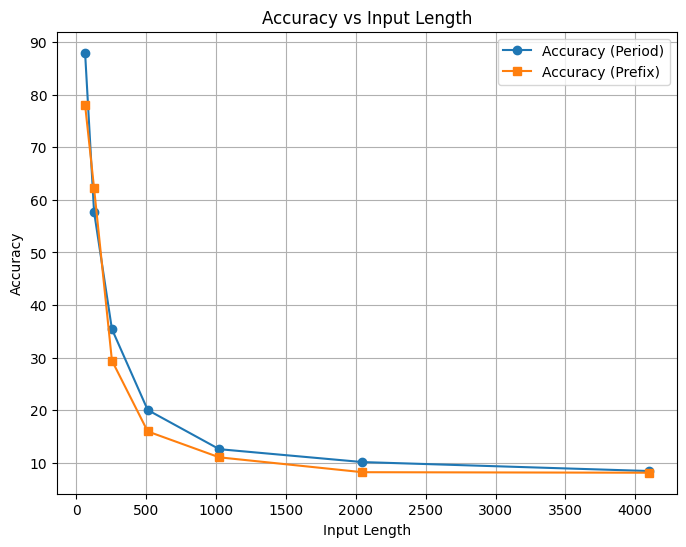

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(input_lengths, accuracy_periods, marker='o', label='Accuracy (Period)')
plt.plot(input_lengths, accuracy_prefixes, marker='s', label='Accuracy (Prefix)')
plt.xlabel('Input Length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Input Length')
plt.legend()
plt.grid(True)
plt.show()

## Interpretability

In [5]:
gpu_number = 3
device = torch.device(f'cuda:{gpu_number}' if torch.cuda.is_available() else 'cpu')

In [6]:
model = torch.load(f'../models/mamba_16.pth', weights_only=False).to(device)

In [15]:
test_dataloader = get_loader(input_length=1024, vary_length=False, batch_size=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 2484.42it/s]


In [39]:
results = []
model.eval()
with torch.no_grad():
    pbar = tqdm(test_dataloader, desc="Inference")
    for batch in pbar:
        inputs, labels = unpack_batch(batch)
        if inputs is None:
            continue
        inputs, labels = inputs.to(device), labels.to(device)


        one_sample = inputs[0]
        
        first_15_idx = (one_sample == 15).nonzero()[0].item()
        target_token = one_sample[first_15_idx + 1].item()

        local_results = []
        for i in range(1, 1024):
            if first_15_idx + 1 + i >= len(one_sample):
                break
            
            prefix = one_sample[:first_15_idx + 1 + i]

            input_seq = torch.cat([prefix, torch.tensor([15], device=one_sample.device)])
            input_seq = input_seq.unsqueeze(0)  # batch dimension
    
            outputs = model(input_seq, num_last_tokens=1)
            logits = outputs.logits  # [1, 1, vocab_size]
            logits = outputs.logits[:, 0, :]
            probs = torch.softmax(logits, dim=-1).squeeze()

            local_results.append(probs[target_token].item())

        results.append(local_results)

Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [57:17<00:00,  1.16it/s]


In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
max_len = max(len(seq) for seq in results)

In [43]:
padded_results = np.full((len(results), max_len), np.nan)
for i, seq in enumerate(results):
    padded_results[i, :len(seq)] = seq

In [45]:
mean_probs = np.nanmean(padded_results, axis=0)

In [46]:
mean_probs

array([0.25775429, 0.78248494, 0.78757767, ..., 0.07158125, 0.10075482,
       0.00121287], shape=(1023,))

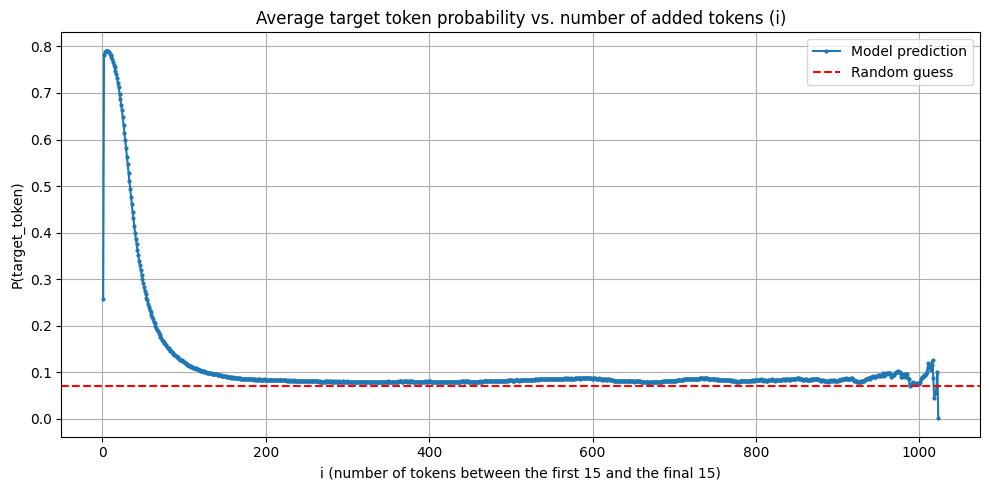

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mean_probs) + 1), mean_probs, marker='o', markersize=2, label="Model prediction")
plt.axhline(y=1/14, color='red', linestyle='--', label="Random guess")

plt.title("Average target token probability vs. number of added tokens (i)")
plt.xlabel("i (number of tokens between the first 15 and the final 15)")
plt.ylabel("P(target_token)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
num_tokens = 10
period = 40

In [54]:
special_period = torch.load(f'../models/period_{num_tokens}.pth', weights_only=False).to(device)
special_prefix = torch.load(f'../models/prefix_{num_tokens}.pth', weights_only=False).to(device)

criterion = nn.CrossEntropyLoss()

In [92]:
token_15_id = torch.tensor([[15]], device=device)  # shape [1, 1]
token_15_embed = model.backbone.embedding(token_15_id)

In [93]:
token_15_embed

tensor([[[ 0.0995, -0.0632,  0.1012, -0.0511, -0.0233, -0.0445, -0.0112,
          -0.0349]]], device='cuda:3', grad_fn=<EmbeddingBackward0>)

In [94]:
def get_prob_from_embed(prefix_embed, model, target_token):
    # Concatenate to prefix
    full_embed = torch.cat([prefix_embed, token_15_embed], dim=1)  # [1, seq_len+1, embed_dim]

    # Forward pass
    with torch.no_grad():
        logits = model(full_embed, is_embeds=True, num_last_tokens=1).logits  # [1, 1, vocab_size]
        probs = F.softmax(logits[:, -1, :], dim=-1)  # [1, vocab_size]
        prob_target = probs[0, target_token].item()

    return prob_target

In [95]:
# Get input
one_sample = inputs[0]  # shape: [seq_len]

# Find target token
first_15_idx = (one_sample == 15).nonzero()[0].item()
target_token = one_sample[first_15_idx + 1].item()

model.eval()
with torch.no_grad():
    embed = model.backbone.embedding(one_sample.unsqueeze(0))

one_sample_with_special = add_special_token(
    embed,
    special_token=special_period,
    period=period,
    tokens_num=num_tokens
)

In [101]:
one_sample_with_special.size()

torch.Size([1, 1285, 8])

In [96]:
first_15_idx = (one_sample_with_special[0] == token_15_embed[0][0]).nonzero()[0][0].item()

In [112]:
model.eval()
probs_local = []
with torch.no_grad():
    for i in range(1, 100):  # Adjust max length if needed
        end_idx = first_15_idx + 1 + i
        if end_idx >= one_sample.size(0):
            break
        if (end_idx - 1) % (period + num_tokens) >= num_tokens:
            # ---- Get token prefix and embed it ----
            prefix = one_sample_with_special[:, :end_idx, :]
    
            # ---- Without special tokens ----
            prob_clean = get_prob_from_embed(prefix, model, target_token)
            probs_local.append(prob_clean)
            if end_idx % (period + num_tokens) == 0:
                probs_local.append(-1)

In [195]:
probs_global = []
model.eval()
with torch.no_grad():
    pbar = tqdm(test_dataloader, desc="Inference")
    for i, batch in enumerate(pbar):
        inputs, labels = unpack_batch(batch)
        if inputs is None:
            continue
        inputs, labels = inputs.to(device), labels.to(device)

        # Get input
        one_sample = inputs[0]  # shape: [seq_len]
        
        # Find target token
        first_15_idx = (one_sample == 15).nonzero()[0].item()
        target_token = one_sample[first_15_idx + 1].item()
        
        model.eval()
        with torch.no_grad():
            embed = model.backbone.embedding(one_sample.unsqueeze(0))
        
        one_sample_with_special = add_special_token(
            embed,
            special_token=special_period,
            period=period,
            tokens_num=num_tokens
        )

        first_15_idx = (one_sample_with_special[0] == token_15_embed[0][0]).nonzero()[0][0].item()

        model.eval()
        probs_local = []
        with torch.no_grad():
            for i in range(1, 1024):  # Adjust max length if needed
                end_idx = first_15_idx + 1 + i
                if end_idx >= one_sample.size(0):
                    break
                if (end_idx - 1) % (period + num_tokens) >= num_tokens:
                    # ---- Get token prefix and embed it ----
                    prefix = one_sample_with_special[:, :end_idx, :]
            
                    # ---- Without special tokens ----
                    prob_clean = get_prob_from_embed(prefix, model, target_token)
                    probs_local.append(prob_clean)
                    if end_idx % (period + num_tokens) == 0:
                        probs_local.append(-1)
        probs_global.append(probs_local)

Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [35:02<00:00,  1.90it/s]


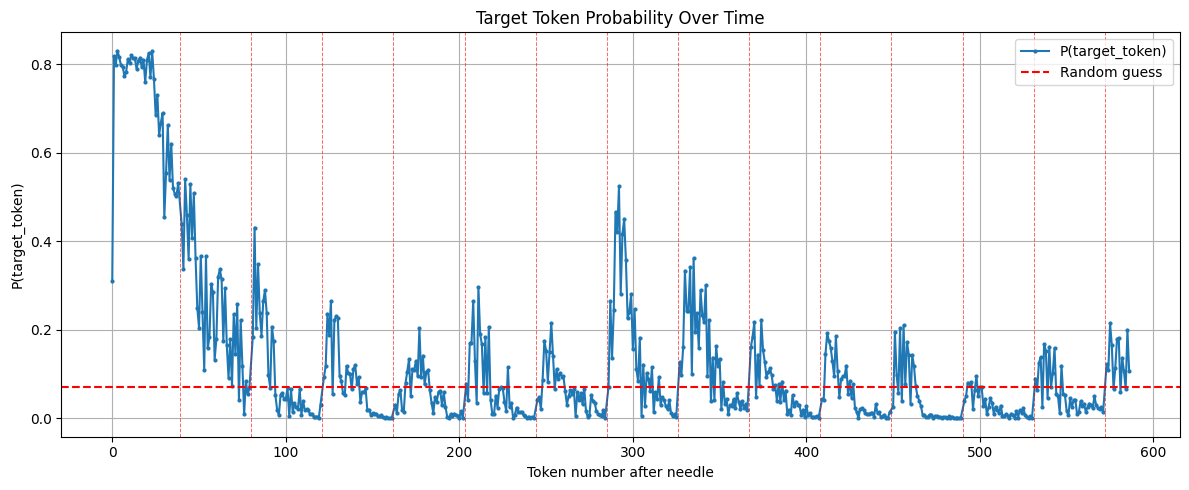

In [196]:
import matplotlib.pyplot as plt
import numpy as np

# Your raw list of values (with -1 placeholders)
raw_values = probs_global[1]  # paste your full list here

# Convert to numpy array for easier processing
values = np.array(raw_values, dtype=float)

# Get indices of valid values and -1 values
valid_mask = values != -1
valid_indices = np.where(valid_mask)[0]
valid_values = values[valid_mask]

missing_indices = np.where(values == -1)[0]

# Plot the valid values
plt.figure(figsize=(12, 5))
plt.plot(valid_indices, valid_values, label="P(target_token)", marker='o', markersize=2)

# Mark where -1s occurred (e.g. with vertical dashed lines)
for idx in missing_indices:
    plt.axvline(x=idx, color='red', linestyle='--', linewidth=0.7, alpha=0.6)

plt.axhline(y=1/14, color='red', linestyle='--', label="Random guess")


# Optional: make the plot more readable
plt.title("Target Token Probability Over Time")
plt.xlabel("Token number after needle")
plt.ylabel("P(target_token)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [197]:
window = 40
all_deltas = [[] for _ in range(window)]  # one list per offset t=0..39

for probs_local in probs_global:
    arr = np.array(probs_local, dtype=float)
    for i in range(1, len(arr) - 1):
        if arr[i] == -1:
            before = arr[i - 1]
            for t in range(window):
                idx = i + 1 + t
                if idx >= len(arr):
                    break
                val = arr[idx]
                if val == -1:
                    print("WTF?")
                delta = (val - before)
                all_deltas[t].append(delta)

# Average over all collected deltas at each time step
mean_deltas = np.array([np.mean(d) if len(d) > 0 else np.nan for d in all_deltas])
median_deltas = np.array([np.median(d) if len(d) > 0 else np.nan for d in all_deltas])

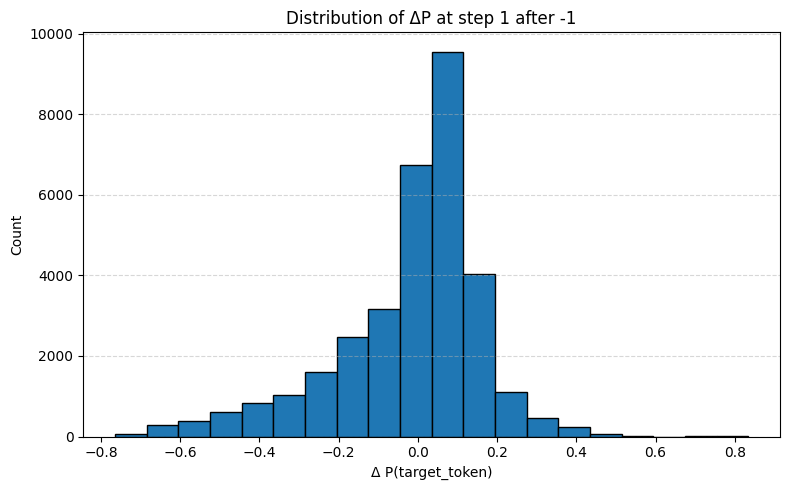

In [198]:
plt.figure(figsize=(8, 5))
plt.hist(all_deltas[0], bins=20, edgecolor='black')
plt.title("Distribution of ΔP at step 1 after -1")
plt.xlabel("Δ P(target_token)")
plt.ylabel("Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

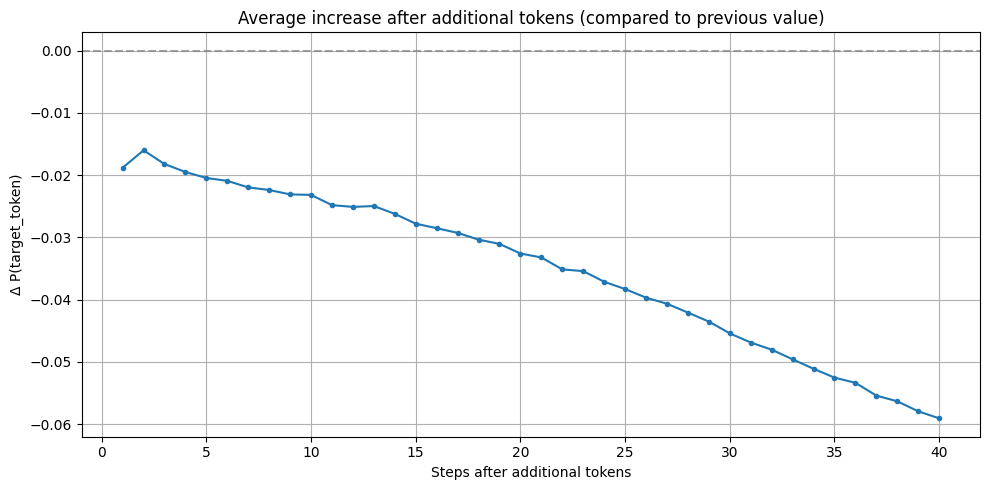

In [199]:
# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mean_deltas) + 1), mean_deltas, marker='o', markersize=3)
plt.axhline(y=0, linestyle='--', color='gray', alpha=0.7)
plt.title("Average increase after additional tokens (compared to previous value)")
plt.xlabel("Steps after additional tokens")
plt.ylabel("Δ P(target_token)")
plt.grid(True)
plt.tight_layout()
plt.show()

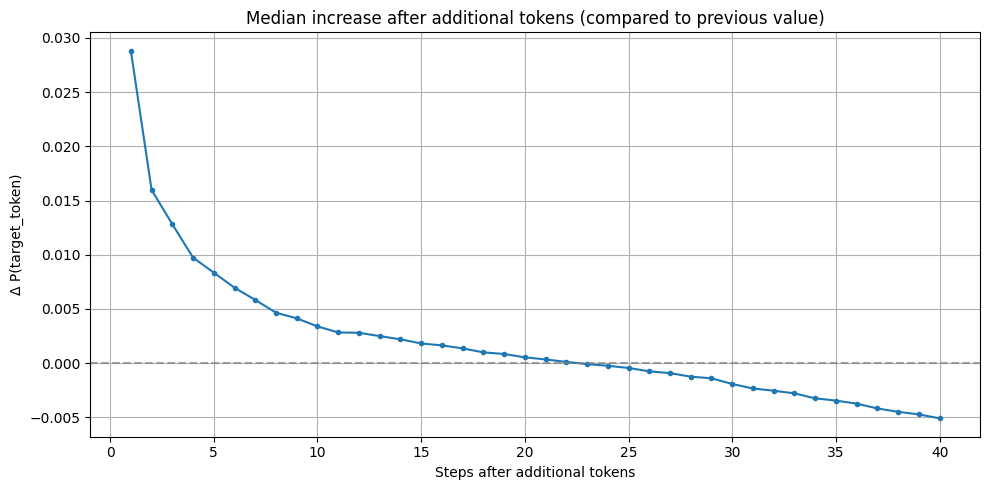

In [200]:
# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(median_deltas) + 1), median_deltas, marker='o', markersize=3)
plt.axhline(y=0, linestyle='--', color='gray', alpha=0.7)
plt.title("Median increase after additional tokens (compared to previous value)")
plt.xlabel("Steps after additional tokens")
plt.ylabel("Δ P(target_token)")
plt.grid(True)
plt.tight_layout()
plt.show()